<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
pip install -U gensim

  Attempting uninstall: gensim
    Found existing installation: gensim 3.4.0
    Uninstalling gensim-3.4.0:
      Successfully uninstalled gensim-3.4.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# get stopwords
STOPWORDS = set(STOPWORDS).union(set(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this', ' ']))

In [4]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [5]:
# To remove emails and newline characters: 
# Convert to list
data = df.full_review_text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-60024a6c435c>:6: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-5-60024a6c435c>:9: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


[' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? ']


In [6]:
# tokenize and clean the text
def sent_to_words(doc):
    for sentence in doc:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['check', 'in', 'love', 'love', 'loved', 'the', 'atmosphere', 'every', 'corner', 'of', 'the', 'coffee', 'shop', 'had', 'its', 'own', 'style', 'and', 'there', 'were', 'swings', 'ordered', 'the', 'matcha', 'latte', 'and', 'it', 'was', 'muy', 'fantastico', 'ordering', 'and', 'getting', 'my', 'drink', 'were', 'pretty', 'streamlined', 'ordered', 'on', 'an', 'ipad', 'which', 'included', 'all', 'beverage', 'selections', 'that', 'ranged', 'from', 'coffee', 'to', 'wine', 'desired', 'level', 'of', 'sweetness', 'and', 'checkout', 'system', 'got', 'my', 'latte', 'within', 'minutes', 'was', 'hoping', 'for', 'typical', 'heart', 'or', 'feather', 'on', 'my', 'latte', 'but', 'found', 'myself', 'listing', 'out', 'all', 'the', 'possibilities', 'of', 'what', 'the', 'art', 'may', 'be', 'any', 'ideas']]


In [7]:
# To create bigram and trigram models:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['check', 'in', 'love', 'love', 'loved', 'the', 'atmosphere', 'every', 'corner', 'of', 'the', 'coffee', 'shop', 'had', 'its', 'own', 'style', 'and', 'there', 'were', 'swings', 'ordered', 'the', 'matcha', 'latte', 'and', 'it', 'was', 'muy', 'fantastico', 'ordering', 'and', 'getting', 'my', 'drink', 'were', 'pretty', 'streamlined', 'ordered', 'on', 'an', 'ipad', 'which', 'included', 'all', 'beverage', 'selections', 'that', 'ranged', 'from', 'coffee', 'to', 'wine', 'desired', 'level', 'of', 'sweetness', 'and', 'checkout', 'system', 'got', 'my', 'latte', 'within', 'minutes', 'was', 'hoping', 'for', 'typical', 'heart', 'or', 'feather', 'on', 'my', 'latte', 'but', 'found', 'myself', 'listing', 'out', 'all', 'the', 'possibilities', 'of', 'what', 'the', 'art', 'may', 'be', 'any', 'ideas']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['check', 'love', 'love', 'love', 'atmosphere', 'corner', 'coffee', 'shop', 'style', 'swing', 'order', 'matcha', 'latte', 'order', 'get', 'drink', 'pretty', 'streamlined', 'order', 'ipad', 'include', 'beverage', 'selection', 'range', 'coffee', 'wine', 'desire', 'level', 'sweetness', 'checkout', 'get', 'latte', 'minute', 'hope', 'typical', 'heart', 'feather', 'latte', 'listing', 'possibility', 'art', 'idea']]


In [10]:
# To create the dictionary and corpus needed for topic modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]]


In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('art', 1),
  ('atmosphere', 1),
  ('beverage', 1),
  ('check', 1),
  ('checkout', 1),
  ('coffee', 2),
  ('corner', 1),
  ('desire', 1),
  ('drink', 1),
  ('feather', 1),
  ('get', 2),
  ('heart', 1),
  ('hope', 1),
  ('idea', 1),
  ('include', 1),
  ('ipad', 1),
  ('latte', 3),
  ('level', 1),
  ('listing', 1),
  ('love', 3),
  ('matcha', 1),
  ('minute', 1),
  ('order', 3),
  ('possibility', 1),
  ('pretty', 1),
  ('range', 1),
  ('selection', 1),
  ('shop', 1),
  ('streamlined', 1),
  ('style', 1),
  ('sweetness', 1),
  ('swing', 1),
  ('typical', 1),
  ('wine', 1)]]

In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.236*"vegan" + 0.109*"customer_service" + 0.069*"environment" + 0.044*"slightly" + 0.042*"frequent" + 0.035*"pro" + 0.033*"notch" + 0.029*"con" + 0.017*"hair" + 0.009*"remotely"'), (1, '0.209*"espresso" + 0.135*"brew" + 0.089*"updated_review" + 0.051*"establishment" + 0.044*"refreshing" + 0.035*"double" + 0.028*"overcook" + 0.019*"normally" + 0.017*"stumptown" + 0.016*"scratch"'), (2, '0.125*"vanilla" + 0.112*"mocha" + 0.076*"lavender" + 0.052*"venue" + 0.052*"almond_milk" + 0.051*"soy" + 0.047*"homemade" + 0.044*"efficient" + 0.042*"syrup" + 0.026*"rosemary"'), (3, '0.213*"night" + 0.175*"dessert" + 0.131*"today" + 0.061*"prepare" + 0.054*"delish" + 0.040*"cost" + 0.020*"rave" + 0.007*"penny" + 0.000*"sandwich" + 0.000*"salad"'), (4, '0.060*"price" + 0.051*"ask" + 0.046*"kind" + 0.034*"give" + 0.028*"leave" + 0.027*"choice" + 0.022*"pay" + 0.022*"high" + 0.022*"pick" + 0.021*"hear"'), (5, '0.174*"dish" + 0.114*"arrive" + 0.105*"face" + 0.075*"smile" + 0.061*"almond" + 0.039*"re

In [14]:
# To compute model perplexity and coherence scores:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence-Score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=data_lemmatized,
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# they are measures of how good a topic model is; focus on coherence


Perplexity:  -12.302974093048423

Coherence Score:  0.37006197575747346


In [15]:
# To visualize the keywords of topics:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# Each bubble represents a topic, with its size related to 
#  the topic's prevalence. Good topic models should have distinct, 
#  large, unclustered  bubbles

C:\Users\daani\AppData\Local\Programs\Python\Python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.367618  0.205349       1        1  44.558300
6      0.364658  0.190277       2        1  27.593752
15     0.253673 -0.212705       3        1   9.582684
4      0.159715 -0.294645       4        1   5.389163
8      0.032495 -0.059669       5        1   1.960035
12     0.052220 -0.089194       6        1   1.860381
9      0.016096 -0.046155       7        1   1.373288
7     -0.017358 -0.016366       8        1   1.339984
1     -0.089099  0.023998       9        1   0.822195
18    -0.065717  0.013282      10        1   0.749150
19    -0.055404  0.007886      11        1   0.747124
16    -0.089545  0.024197      12        1   0.678035
2     -0.098664  0.027661      13        1   0.662921
14    -0.085121  0.022382      14        1   0.604014
0     -0.100555  0.028357      15        1   0.582941
3     -0.088287  0.023581      16        1   0.551008
5     -0.104180  0.029609      17        1   0.408825
13    -0.131282  0.037391      18        1   0.396255
10    -0.154375  0.041398      19        1   0.129864
17    -0.166887  0.043366      20        1   0.010083, topic_info=     Category         Freq                 Term        Total  loglift  logprob
90    Default  5857.000000                  not  5857.000000  30.0000  30.0000
54    Default  5099.000000                   be  5099.000000  29.0000  29.0000
5     Default  8260.000000               coffee  8260.000000  28.0000  28.0000
129   Default  6898.000000                 good  6898.000000  27.0000  27.0000
204   Default  1224.000000                 beer  1224.000000  26.0000  26.0000
97    Default  7728.000000                place  7728.000000  25.0000  25.0000
78    Default  6090.000000                great  6090.000000  24.0000  24.0000
142   Default  2041.000000                table  2041.000000  23.0000  23.0000
62    Default   911.000000            chocolate   911.000000  22.0000  22.0000
69    Default  3453.000000                   do  3453.000000  21.0000  21.0000
430   Default  3432.000000                 time  3432.000000  20.0000  20.0000
190   Default  1041.000000                    s  1041.000000  19.0000  19.0000
22    Default  3235.000000                order  3235.000000  18.0000  18.0000
560   Default  1921.000000                 work  1921.000000  17.0000  17.0000
448   Default  1577.000000                 game  1577.000000  16.0000  16.0000
88    Default  1624.000000                  lot  1624.000000  15.0000  15.0000
223   Default  3226.000000                 have  3226.000000  14.0000  14.0000
3     Default  4182.000000                check  4182.000000  13.0000  13.0000
187   Default  1109.000000                price  1109.000000  12.0000  12.0000
429   Default  3919.000000                  tea  3919.000000  11.0000  11.0000
343   Default  3490.000000                 come  3490.000000  10.0000  10.0000
534   Default   587.000000             espresso   587.000000   9.0000   9.0000
1328  Default   655.000000                scone   655.000000   8.0000   8.0000
61    Default   710.000000              chicken   710.000000   7.0000   7.0000
953   Default   940.000000                  ask   940.000000   6.0000   6.0000
191   Default  1295.000000                  sit  1295.000000   5.0000   5.0000
42    Default  2168.000000                   go  2168.000000   4.0000   4.0000
19    Default  3434.000000                 love  3434.000000   3.0000   3.0000
1046  Default   523.000000           restaurant   523.000000   2.0000   2.0000
756   Default   842.000000                 kind   842.000000   1.0000   1.0000
...       ...          ...                  ...          ...      ...      ...
5143  Topic20     0.002689             postcard     1.041042   3.2433  -9.4556
4267  Topic20     0.002689               brians     1.041036   3.2433  -9.4556
4265  Topic20     0.002689          practically     1.041050   3.2433  -9.4556
4264

In [16]:
# To find optimal number of topics (for LDA):
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus, 
                                            texts=data_lemmatized, 
                                            start=2, limit=40, step=6)

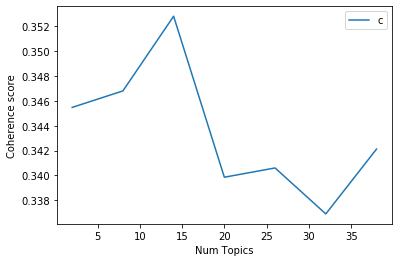

In [18]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print coherence scores 
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3455
Num Topics = 8  has Coherence Value of 0.3468
Num Topics = 14  has Coherence Value of 0.3528
Num Topics = 20  has Coherence Value of 0.3399
Num Topics = 26  has Coherence Value of 0.3406
Num Topics = 32  has Coherence Value of 0.3369
Num Topics = 38  has Coherence Value of 0.3421


In [20]:
# Select best model from listing (here, it's the first model, with 2 topics)
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)

# output the topics of the selected LDA model
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"coffee" + 0.016*"place" + 0.015*"be" + 0.014*"not" + 0.013*"great" + '
  '0.013*"good" + 0.010*"check" + 0.008*"do" + 0.008*"drink" + 0.008*"come"'),
 (1,
  '0.039*"coffee" + 0.018*"place" + 0.016*"good" + 0.012*"not" + 0.010*"great" '
  '+ 0.010*"check" + 0.009*"be" + 0.008*"shop" + 0.008*"love" + 0.007*"come"')]


In [21]:
# To find dominant topic in each doc:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

# Feature Dominant_Topic tells which of the topics is most dominant
#  for a given document. In this case, as there are only two topics,
#  1.0 and 0.0 are the only listed values

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7644,"coffee, place, good, not, great, check, be, sh...",11/25/2016 1 check-in Love love loved the atm...
1,1,0.0,0.9488,"coffee, place, be, not, great, good, check, do...","12/2/2016 Listed in Date Night: Austin, Ambia..."
2,2,0.0,0.8657,"coffee, place, be, not, great, good, check, do...",11/30/2016 1 check-in Listed in Brunch Spots ...
3,3,0.0,0.5559,"coffee, place, be, not, great, good, check, do...",11/25/2016 Very cool decor! Good drinks Nice ...
4,4,0.0,0.7890,"coffee, place, be, not, great, good, check, do...",12/3/2016 1 check-in They are located within ...


In [22]:
# To find the most representative document for each topic:
#  can be used to get a better idea of what a topic is 

# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9948,"coffee, place, be, not, great, good, check, do...",8/6/2014 1 check-in Three stars is actually r...
1,1.0,0.9968,"coffee, place, good, not, great, check, be, sh...",7/20/2014 South Austin enterprise on Manchaca...


In [23]:
# To get the distribution of topics across documents:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

NameError: name 'sent_topics_sorteddf_mallet' is not defined

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling